In [47]:
import pythia8
from pyjet import cluster, DTYPE_PTEPM
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap
plt.style.use("dark_paper")

In [112]:
def prtStable(pid):
    if abs(pid) == 211: return True #pion
    if abs(pid) == 321: return True #K+-
    if abs(pid) == 11: return True #electron
    if abs(pid) == 13: return True #muon
    if abs(pid) == 2212: return True #proton
    #
    #if abs(pid) == 22: return True #gamma
    #if abs(pid) == 130: return True #K_l
    return False
def heavyFlavor(pid):
    if abs(pid) == 411: return True
    if abs(pid) == 421: return True
    if abs(pid) == 431: return True
    if abs(pid) == 4122: return True
    if abs(pid) == 511: return True
    if abs(pid) == 521: return True
    if abs(pid) == 531: return True
    if abs(pid) == 5122: return True
    return False
def getData(prt):
    data = [prt.index(),prt.name(),prt.id(),prt.status(),prt.mother1(),prt.mother2(),
            prt.daughter1(),prt.daughter2(),prt.e(),prt.px(),prt.py(),prt.pz(),prt.m(),prt.pT(),prt.eta(),prt.phi(),prt.theta()]
    keys = ["N","NAME","ID","STATUS","M1","M2","D1","D2","E", "px", "py", "pz" , "mass","pT","eta","phi","theta"]
    return {key:value for key,value in zip(keys,data)}
def getDataLite(prt):
    data = [prt.index(), prt.e(),prt.px(),prt.py(),prt.pz()]
    keys = ["N", "E", "px", "py", "pz"]
    return {key:value for key,value in zip(keys,data)}
def getInfo(prt):
    string = "{:^2d} {:^11s} {:^5d} {:^6d} {:<3d} {:>3d}  {:<3d} {:>3d}    ".format(prt.index(),prt.name(),prt.id(),
                                                                       prt.status(),
                                                                       prt.mother1(),prt.mother2(),
                                                                       prt.daughter1(),prt.daughter2())
    string += (6*" {:>8.3f} ").format(prt.e(),prt.px(),prt.py(),prt.pz(),prt.m(),prt.pT())
    return string

In [152]:
# Setup Pythia Parameters
# Generator. Shorthand for event.
pythia = pythia8.Pythia()

# Set up incoming beams, for frame with equal beam energies.
# BeamA = proton.
pythia.readString("Beams:idA = 2212")
pythia.readString("Beams:idB = 2212")
pythia.settings.parm("Beams:eCM", 14000.)
# QCD pp
# pythia.readString("HardQCD:all = on");
# pythia.readString("PhaseSpace:pTHatMin = 200.")

# Process selection.
pythia.readString("WeakSingleBoson:ffbar2W = on");
# Switch off all W decays and then switch back on those to quarks.
pythia.readString("24:onMode = off");
pythia.readString("24:onIfAny = 1 2 3 4 5");
pythia.readString("PhaseSpace:pTHat5Min = 600");


# Initialize.
print("Pythia generator initialized successfully: ", pythia.init())

Pythia generator initialized successfully:  True


In [146]:
def selection(prt):
    sel = prt.isFinal() and prt.vProd().pAbs()<1000 #and prtStable(prt.id()) # and prt.isCharged()
    return sel

In [153]:
# Full Verbose for Debugging
nEvents = 10
events = list()
W_pt = []
iEvent = 0
while iEvent < nEvents:
    if not pythia.next(): continue
    event = pythia.event 
    W = [prt for prt in event if abs(prt.id())==24][-1]
    if W.pT()<100: 
        continue
    else: 
        iEvent +=1
    print("=="*20 + f" Event {iEvent:^3d}/{nEvents:^3d} " + "=="*20)
    print(("{:^2s} {:^11s} {:^5s} {:^6s} {:^8s} {:^8s} {:^8s}   " + 5*"{:^10s}").format("N","NAME","ID","STATUS","PARENTS","CHILDREN","E", "px", "py", "pz" , "m", "pT"))
    df = pd.DataFrame(columns=["N","NAME","ID","STATUS","M1","M2","D1","D2","E", "px", "py", "pz" , "mass","eta","phi","theta"])
    
    for prt in event:
        print(getInfo(prt))
        if selection(prt):
            df = df.append(getData(prt),ignore_index=True)
        if abs(prt.id())==24: 
            index = prt.index()
            print("-"*100)
    W_pt.append(W.pT())
    df = df.append(getData(W),ignore_index=True)
    df.name = f"Event {iEvent}"
    #get outgoing parton daughters
    fs_daughters = np.unique([daughterid for daughterid in W.daughterListRecursive()\
                    if selection(event[daughterid])])
    mask = np.zeros(len(df)).astype("int")
    mask[df.N.isin(fs_daughters).tolist()] = 1
    df["mask"] = mask
    events.append(df)

======================================== Event  1 /10  ========================================
N     NAME      ID   STATUS PARENTS  CHILDREN    E           px        py        pz        m         pT    
0    system     90    -11   0     0  0     0     14000.000     0.000     0.000     0.000  14000.000     0.000 
1      p+      2212   -12   0     0  411   0     7000.000     0.000     0.000  7000.000     0.938     0.000 
2      p+      2212   -12   0     0  412   0     7000.000     0.000     0.000  -7000.000     0.938     0.000 
3     cbar      -4    -21   6     0  5     0       74.569     0.000     0.000    74.569     0.000     0.000 
4       d        1    -21   7     7  5     0       20.706     0.000     0.000   -20.706     0.000     0.000 
5      W-       -24   -22   3     4  8     8       95.276     0.000     0.000    53.863    78.589     0.000 
----------------------------------------------------------------------------------------------------
6       g       21    -41   10    0  9

647    pbar-    -2212   84   632 640  0     0       17.422     3.548    -1.654    16.951     0.938     3.914 
648     pi+      211    84   632 640  0     0        5.214     1.301    -0.596     5.011     0.140     1.431 
649     eta      221   -84   632 640  1145 1146       12.148     2.483    -1.370    11.800     0.548     2.835 
650     n0      2112    84   632 640  0     0       97.661    21.724    -8.328    94.845     0.940    23.266 
651    nbar0    -2112   84   632 640  0     0      182.327    39.396   -15.924   177.303     0.940    42.493 
652     D*-     -413   -84   632 640  1147 1148      274.918    60.077   -23.784   267.209     2.010    64.613 
653      c        4    -71   414 414  667 698       23.674    -8.747     0.473    21.943     1.500     8.760 
654      g       21    -71   428 428  667 698       99.649   -36.318    -0.038    92.795     0.000    36.318 
655      g       21    -71   421 421  667 698       22.139    -4.793     1.574    21.557     0.000     5.044 
656   

782     K0       311   -86   748 767  1026 1026      200.369    -0.229    -0.099  -200.368     0.498     0.249 
783     phi      333   -86   748 767  1210 1211        4.807    -0.431    -0.166    -4.675     1.019     0.462 
784   K*bar0    -313   -86   748 767  1027 1028        6.204     0.727     0.390    -6.078     0.926     0.825 
785     eta      221   -83   748 767  1212 1214       13.300    -0.148    -0.488   -13.279     0.548     0.510 
786     n0      2112    83   748 767  0     0        8.349    -0.134     0.373    -8.286     0.940     0.396 
787    pbar-    -2212   83   748 767  0     0        0.970    -0.028     0.191    -0.151     0.938     0.193 
788     pi0      111   -83   748 767  1215 1216        0.164     0.073    -0.016     0.054     0.135     0.075 
789    rho+      213   -83   748 767  1029 1030        0.794     0.159    -0.315     0.003     0.711     0.353 
790    rho0      113   -83   748 767  1031 1032        0.884     0.094    -0.336     0.506     0.636     0.3

915    omega     223   -84   825 861  1273 1275        1.217    -0.214    -0.822     0.335     0.804     0.850 
916   Delta+    2214   -84   825 861  1099 1100        3.128     0.635     0.124     2.816     1.198     0.647 
917     eta      221   -84   825 861  1276 1278        1.866     0.006    -1.110     1.397     0.548     1.110 
918    pbar-    -2212   84   825 861  0     0        1.521     0.511    -0.791     0.739     0.938     0.942 
919     pi+      211    84   825 861  0     0        0.381    -0.009     0.337     0.110     0.140     0.337 
920    eta'      331   -84   825 861  1279 1281        1.310    -0.114     0.304     0.832     0.958     0.325 
921     pi0      111   -84   825 861  1282 1283        2.366     0.395     0.380    -2.297     0.135     0.548 
922     pi0      111   -84   825 861  1284 1285        3.083     1.140     0.387    -2.835     0.135     1.204 
923    rho-     -213   -84   825 861  1101 1102        2.222     0.412     0.167    -2.030     0.785     0.4

997     pi0      111   -91   723   0  1334 1335        0.522    -0.411     0.227     0.184     0.135     0.470 
998    K_L0      130    91   726 726  0     0       17.053   -15.282    -0.707     7.517     0.498    15.299 
999    K_L0      130    91   727 727  0     0       48.291   -42.735    -3.488    22.211     0.498    42.877 
1000     pi+      211    91   733   0  0     0        6.349    -0.140    -0.211     6.342     0.140     0.253 
1001     pi-     -211    91   733   0  0     0        5.549     0.576     0.062     5.516     0.140     0.579 
1002     pi+      211    91   734   0  0     0        2.746     0.297    -0.251     2.714     0.140     0.389 
1003     pi-     -211    91   734   0  0     0        4.724    -0.155     0.291     4.711     0.140     0.329 
1004     pi-     -211    91   737   0  0     0        1.202    -0.261     0.175     1.151     0.140     0.315 
1005     pi0      111   -91   737   0  1336 1337        0.741     0.014     0.570     0.454     0.135     0.570 


1113    Kbar0    -311   -91   940   0  1128 1128       15.629    -0.299     0.245   -15.616     0.498     0.386 
1114     pi0      111   -91   940   0  1404 1405       20.535     0.071     0.615   -20.525     0.135     0.619 
1115     pi+      211    91   942   0  0     0       10.906    -0.544     0.449   -10.883     0.140     0.705 
1116     pi0      111   -91   942   0  1406 1407        9.966    -0.007    -0.122    -9.964     0.135     0.122 
1117     pi+      211    91   943   0  0     0        2.768     0.059    -0.028    -2.763     0.140     0.065 
1118     pi-     -211    91   943   0  0     0        2.568    -0.295     0.622    -2.471     0.140     0.688 
1119     pi+      211    91   947   0  0     0        4.490    -1.688     0.342    -4.144     0.140     1.722 
1120     pi0      111   -91   947   0  1408 1409        1.672    -0.378    -0.038    -1.622     0.135     0.380 
1121     K+       321    91   949   0  0     0        2.611    -0.787    -0.316    -2.419     0.494     

1232     pi-     -211    91   818   0  0     0        0.670     0.177     0.178    -0.605     0.140     0.251 
1233     pi0      111   -91   818   0  1474 1475        0.489     0.129     0.221    -0.394     0.135     0.256 
1234    gamma     22     91   820   0  0     0        1.269     0.691     0.345    -1.007     0.000     0.772 
1235    gamma     22     91   820   0  0     0        0.803     0.066     0.445    -0.665     0.000     0.450 
1236     pi+      211    91   822   0  0     0        1.852     0.560     0.682    -1.623     0.140     0.882 
1237     pi-     -211    91   822   0  0     0        1.658     0.550     0.415    -1.501     0.140     0.689 
1238     pi0      111   -91   822   0  1476 1477        0.563     0.358     0.066    -0.408     0.135     0.364 
1239    gamma     22     91   865   0  0     0       37.758    -0.175    -0.263   -37.756     0.000     0.315 
1240    gamma     22     91   865   0  0     0       50.469    -0.303    -0.211   -50.468     0.000     0.36

1329    gamma     22     91   989   0  0     0       61.403     0.727     0.904   -61.392     0.000     1.160 
1330    gamma     22     91   991   0  0     0        2.155    -0.021     0.012    -2.155     0.000     0.024 
1331    gamma     22     91   991   0  0     0        9.363    -0.323     0.211    -9.355     0.000     0.386 
1332    gamma     22     91   995   0  0     0        0.314     0.024    -0.243     0.197     0.000     0.244 
1333    gamma     22     91   995   0  0     0        0.029     0.009     0.018     0.022     0.000     0.020 
1334    gamma     22     91   997   0  0     0        0.234    -0.221     0.054     0.053     0.000     0.227 
1335    gamma     22     91   997   0  0     0        0.289    -0.190     0.173     0.131     0.000     0.257 
1336    gamma     22     91   1005   0  0     0        0.012    -0.009    -0.005     0.006     0.000     0.010 
1337    gamma     22     91   1005   0  0     0        0.729     0.023     0.575     0.448     0.000     0.575 

1455    gamma     22     91   1191   0  0     0        3.269     0.006    -0.013     3.269     0.000     0.014 
1456    gamma     22     91   1204   0  0     0        2.818     0.439     0.163     2.778     0.000     0.469 
1457    gamma     22     91   1204   0  0     0        0.022     0.004     0.013     0.018     0.000     0.013 
1458    gamma     22     91   1208   0  0     0        2.286    -0.000     0.009    -2.286     0.000     0.009 
1459    gamma     22     91   1208   0  0     0      506.705    -0.334    -0.068  -506.705     0.000     0.341 
1460     pi+      211    91   1211   0  0     0        1.010     0.047    -0.200    -0.979     0.140     0.205 
1461     pi-     -211    91   1211   0  0     0        1.690    -0.308     0.019    -1.656     0.140     0.309 
1462    gamma     22     91   1212   0  0     0        2.258    -0.066    -0.200    -2.248     0.000     0.211 
1463    gamma     22     91   1212   0  0     0        3.049    -0.024    -0.128    -3.046     0.000    

1544     K0       311   -91   1433   0  1550 1550       77.365    16.434    -6.393    75.327     0.498    17.634 
1545     pi0      111   -91   1433   0  1551 1552       82.080    17.812    -7.135    79.806     0.135    19.188 
1546     K-      -321    91   1436   0  0     0       18.843    -6.768     0.881    17.557     0.494     6.825 
1547     pi+      211    91   1436   0  0     0        5.120    -1.905    -0.068     4.750     0.140     1.907 
1548    gamma     22     91   1437   0  0     0        6.373    -2.573    -0.175     5.828     0.000     2.579 
1549    gamma     22     91   1437   0  0     0       16.465    -5.877    -0.175    15.379     0.000     5.879 
1550    K_L0      130    91   1544 1544  0     0       77.365    16.434    -6.393    75.327     0.498    17.634 
1551    gamma     22     91   1545   0  0     0       36.168     7.864    -3.209    35.156     0.000     8.493 
1552    gamma     22     91   1545   0  0     0       45.912     9.948    -3.927    44.649     0.00

838     pi0      111   -84   820 826  1371 1372        4.809    -0.229    -0.180    -4.799     0.135     0.291 
839     K+       321    84   820 826  0     0       18.357    -0.482    -0.921   -18.321     0.494     1.039 
840    Kbar0    -311   -84   820 826  1164 1164       58.043    -1.922    -3.575   -57.899     0.498     4.060 
841     pi0      111   -84   820 826  1373 1374       63.492    -1.393    -3.712   -63.368     0.135     3.965 
842    rho-     -213   -84   820 826  1165 1166      590.867   -15.527   -36.052  -589.561     0.806    39.254 
843     K+       321    84   820 826  0     0      228.538    -6.229   -13.196  -228.071     0.494    14.593 
844      d        1    -71   647 647  862 895        1.392     0.309     0.492    -1.221     0.330     0.581 
845      g       21    -71   591 591  862 895       12.029    -0.568    -1.688   -11.896     0.000     1.781 
846      g       21    -71   703 703  862 895       11.917     0.463    -2.262   -11.685     0.380     2.309 
84

997    nbar0    -2112   83   960 986  0     0        3.165     0.769    -0.365    -2.900     0.940     0.851 
998     K*0      313   -83   960 986  1231 1232        2.983    -0.702     0.375    -2.760     0.804     0.796 
999    Kbar0    -311   -83   960 986  1233 1233        2.326     0.494    -0.672    -2.113     0.498     0.835 
1000    rho0      113   -83   960 986  1234 1235        3.789     0.033     0.750    -3.606     0.887     0.750 
1001     pi0      111   -83   960 986  1428 1429        0.600    -0.381    -0.174    -0.407     0.135     0.419 
1002    rho0      113   -83   960 986  1236 1237        3.616     0.595    -0.847    -3.373     0.793     1.035 
1003    rho0      113   -83   960 986  1238 1239        2.003    -0.030     0.651    -1.742     0.744     0.652 
1004     pi-     -211    83   960 986  0     0        0.824    -0.655     0.179    -0.445     0.140     0.679 
1005     pi0      111   -83   960 986  1430 1431        1.265    -0.007     0.429    -1.182     0.135  

1132     pi-     -211    91   741   0  0     0        1.633     0.283     0.341     1.565     0.140     0.443 
1133    K_S0      310   -91   750 750  1497 1498       96.650     0.278    -0.207   -96.648     0.498     0.347 
1134    Kbar0    -311   -91   751   0  1305 1305       33.384    -0.320     0.028   -33.378     0.498     0.321 
1135     pi-     -211    91   751   0  0     0       14.478    -0.621    -0.103   -14.464     0.140     0.629 
1136     K0       311   -91   752   0  1306 1306       11.629     0.153    -0.801   -11.590     0.498     0.816 
1137     pi+      211    91   752   0  0     0       20.460    -0.538    -0.673   -20.441     0.140     0.861 
1138    K_L0      130    91   762 762  0     0       10.210     0.297    -0.111    10.193     0.498     0.317 
1139     pi-     -211    91   766   0  0     0       69.237    -0.244     0.751    69.232     0.140     0.790 
1140     pi0      111   -91   766   0  1499 1500      181.646     0.195     0.865   181.644     0.135     

1247     pi0      111   -91   1020   0  1564 1565      109.417     0.179    -0.433   109.416     0.135     0.468 
1248     n0      2112    91   1023   0  0     0     1138.618     0.127    -0.402  1138.618     0.940     0.421 
1249     pi0      111   -91   1023   0  1566 1567      101.239    -0.037    -0.181   101.239     0.135     0.185 
1250     pi-     -211    91   1052   0  0     0      377.683     0.451    -0.134  -377.682     0.140     0.471 
1251     pi0      111   -91   1052   0  1568 1569      181.672    -0.381    -0.008  -181.672     0.135     0.381 
1252     pi+      211    91   1056   0  0     0      161.325    -0.880     0.490   161.322     0.140     1.007 
1253     pi-     -211    91   1056   0  0     0        9.207     0.036    -0.055     9.205     0.140     0.066 
1254     pi-     -211    91   1059   0  0     0        2.083     0.705    -0.274     1.935     0.140     0.756 
1255     pi0      111   -91   1059   0  1570 1571        4.162     0.486     0.012     4.132     0

1341     pi-     -211    91   788   0  0     0        0.280    -0.179    -0.128     0.102     0.140     0.220 
1342     pi0      111   -91   788   0  1612 1613        1.006    -0.895    -0.389     0.206     0.135     0.976 
1343    gamma     22     91   804   0  0     0      103.826     0.166     0.175  -103.826     0.000     0.241 
1344    gamma     22     91   804   0  0     0        9.389    -0.023     0.031    -9.389     0.000     0.038 
1345    gamma     22     91   805   0  0     0       94.955    -0.455    -0.767   -94.951     0.000     0.891 
1346    gamma     22     91   805   0  0     0       43.301    -0.116    -0.355   -43.299     0.000     0.374 
1347    gamma     22     91   806   0  0     0       62.605     0.190     0.801   -62.600     0.000     0.824 
1348    gamma     22     91   806   0  0     0        0.819    -0.003    -0.004    -0.819     0.000     0.005 
1349     pi+      211    91   811   0  0     0        0.900    -0.054     0.292    -0.838     0.140     0.297 

1462     pi-     -211    91   1077   0  0     0        0.540     0.122    -0.052    -0.504     0.140     0.133 
1463     eta      221   -91   1077   0  1680 1682        1.718     0.017    -0.357    -1.588     0.548     0.357 
1464    gamma     22     91   1081   0  0     0       19.877     0.150    -0.084   -19.876     0.000     0.172 
1465     e-       11     91   1081   0  0     0        5.968     0.012    -0.061    -5.968     0.001     0.062 
1466     e+       -11    91   1081   0  0     0        7.681     0.018    -0.082    -7.680     0.001     0.084 
1467     p+      2212    91   1085   0  0     0      123.513    -9.574    -2.838   123.105     0.938     9.986 
1468     pi-     -211    91   1085   0  0     0       27.343    -2.236    -0.631    27.244     0.140     2.324 
1469    nbar0    -2112   91   1086   0  0     0       72.886    -5.565    -2.195    72.634     0.940     5.982 
1470     pi+      211    91   1086   0  0     0       26.101    -2.014    -0.547    26.017     0.140  

1546    gamma     22     91   1211   0  0     0        0.171    -0.039     0.166     0.000     0.000     0.171 
1547    gamma     22     91   1211   0  0     0        0.142    -0.112     0.065     0.058     0.000     0.129 
1548    gamma     22     91   1220   0  0     0       10.428     0.495     0.013   -10.416     0.000     0.495 
1549    gamma     22     91   1220   0  0     0        5.439     0.165    -0.023    -5.437     0.000     0.167 
1550     pi+      211    91   1221   0  0     0        1.238    -0.075     0.147    -1.220     0.140     0.165 
1551     pi-     -211    91   1221   0  0     0        2.592    -0.452    -0.188    -2.542     0.140     0.489 
1552    gamma     22     91   1225   0  0     0       12.081     0.118    -0.076    12.080     0.000     0.140 
1553    gamma     22     91   1225   0  0     0        5.268     0.139    -0.052     5.266     0.000     0.148 
1554    gamma     22     91   1230   0  0     0        0.668     0.066     0.014    -0.665     0.000    

1651    gamma     22     91   1416   0  0     0        0.293     0.165    -0.070    -0.232     0.000     0.179 
1652    gamma     22     91   1417   0  0     0        0.089     0.057    -0.067    -0.015     0.000     0.088 
1653    gamma     22     91   1417   0  0     0        0.131    -0.010    -0.018    -0.130     0.000     0.020 
1654    gamma     22     91   1418   0  0     0        0.289     0.030    -0.146    -0.248     0.000     0.149 
1655    gamma     22     91   1418   0  0     0        0.096    -0.011    -0.093    -0.022     0.000     0.094 
1656     n0      2112    91   1419   0  0     0        6.854     0.288     0.166     6.781     0.940     0.333 
1657     pi0      111   -91   1419   0  1703 1704        1.016     0.064    -0.089     1.001     0.135     0.110 
1658    pbar-    -2212   91   1421   0  0     0       27.394     0.091    -0.074    27.378     0.938     0.118 
1659     pi+      211    91   1421   0  0     0        2.997    -0.021    -0.090     2.992     0.140  

569     pi+      211    83   566 567  0     0        4.678     0.692    -0.361    -4.611     0.140     0.781 
570     pi-     -211    83   566 567  0     0        0.475     0.121     0.331    -0.286     0.140     0.352 
571     pi+      211    83   566 567  0     0        6.145    -0.533    -0.115    -6.119     0.140     0.545 
572    rho-     -213   -83   566 567  772 773      328.118     0.883     0.212  -328.116     0.764     0.908 
573     pi0      111   -84   566 567  894 895       51.168    -0.198    -0.337   -51.166     0.135     0.391 
574    rho+      213   -84   566 567  774 775      682.685    -0.262     0.634  -682.685     0.785     0.686 
575     K0       311   -84   566 567  776 776      524.453     0.550     1.098  -524.452     0.498     1.228 
576     eta      221   -84   566 567  896 897      184.006    -0.458    -0.319  -184.005     0.548     0.558 
577      d        1    -71   434 434  584 597        1.409    -0.305    -0.014     1.336     0.330     0.305 
578      g

719     pi0      111   -83   688 711  937 938        2.293    -0.426     0.014     2.249     0.135     0.427 
720     n0      2112    83   688 711  0     0        3.600    -1.798     0.949     2.819     0.940     2.033 
721     pi0      111   -83   688 711  939 940        0.271     0.157     0.133     0.112     0.135     0.206 
722  Deltabar0  -2114  -83   688 711  830 831        1.688    -0.690     0.295     0.842     1.257     0.750 
723     pi0      111   -83   688 711  941 942        0.873    -0.414    -0.267     0.709     0.135     0.492 
724   Delta-    1114   -83   688 711  832 833        1.846    -0.414    -1.295     0.301     1.211     1.359 
725     eta      221   -83   688 711  943 944        0.630     0.265    -0.159    -0.045     0.548     0.308 
726  Deltabar+  -1114  -83   688 711  834 835        2.268     0.170    -1.550    -0.986     1.319     1.560 
727    omega     223   -83   688 711  945 947        1.146     0.584     0.246    -0.542     0.786     0.634 
728     pi

822     pi0      111   -91   686   0  1000 1001        1.080     0.850     0.274     0.592     0.135     0.893 
823    K_S0      310   -91   687 687  1002 1003        0.922     0.023    -0.453     0.629     0.498     0.454 
824     K-      -321    91   712   0  0     0        7.553    -0.202     0.817    -7.490     0.494     0.841 
825     pi+      211    91   712   0  0     0       14.710    -0.508     1.145   -14.656     0.140     1.253 
826     pi-     -211    91   713   0  0     0       15.595    -0.323     1.059   -15.555     0.140     1.107 
827     pi0      111   -91   713   0  1004 1005        1.657    -0.169    -0.065    -1.642     0.135     0.181 
828     pi+      211    91   714   0  0     0        1.256     0.336     0.031    -1.202     0.140     0.338 
829     pi0      111   -91   714   0  1006 1007        2.535    -0.332    -0.132    -2.506     0.135     0.357 
830    nbar0    -2112   91   722   0  0     0        1.411    -0.686     0.057     0.797     0.940     0.688 
83

928    gamma     22     91   681   0  0     0        3.555    -0.313     0.393     3.520     0.000     0.502 
929    gamma     22     91   682   0  0     0        0.956    -0.220    -0.140     0.920     0.000     0.261 
930    gamma     22     91   682   0  0     0        0.624    -0.040    -0.123     0.611     0.000     0.129 
931     pi0      111   -91   683   0  1048 1049        0.498     0.112    -0.078     0.459     0.135     0.136 
932     pi0      111   -91   683   0  1050 1051        0.982     0.150    -0.039     0.960     0.135     0.155 
933     pi0      111   -91   683   0  1052 1053        1.993     0.105    -0.102     1.983     0.135     0.146 
934     pi0      111   -91   716   0  1054 1055        0.613    -0.058     0.036    -0.594     0.135     0.068 
935     pi0      111   -91   716   0  1056 1057        0.283    -0.091    -0.006    -0.231     0.135     0.091 
936     pi0      111   -91   716   0  1058 1059        0.534    -0.184    -0.193    -0.442     0.135     0.267

1021     pi-     -211    91   854   0  0     0        0.393    -0.024     0.022    -0.366     0.140     0.033 
1022     pi+      211    91   855   0  0     0       95.227    15.214    36.364    86.685     0.140    39.419 
1023     pi-     -211    91   855   0  0     0       13.426     2.164     5.037    12.255     0.140     5.482 
1024     pi+      211    91   856   0  0     0        1.265     0.211     0.455     1.153     0.140     0.502 
1025     pi-     -211    91   856   0  0     0       10.445     1.178     3.981     9.584     0.140     4.151 
1026     pi+      211    91   857   0  0     0        8.425    -1.387    -1.786     8.115     0.140     2.261 
1027     pi-     -211    91   857   0  0     0       57.418    -9.334   -12.854    55.177     0.140    15.885 
1028     pi+      211    91   859   0  0     0       32.306     0.329    -0.006    32.304     0.140     0.329 
1029     pi-     -211    91   859   0  0     0      108.586     0.458    -0.224   108.585     0.140     0.509 
1

324      u        2    -71   167 167  342 368     1185.849     1.479     0.995  1185.848     0.330     1.783 
325      g       21    -71   161 161  342 368      246.071    -3.010    -1.754   246.046     0.000     3.483 
326      g       21    -71   164 164  342 368        0.927    -0.190    -0.027     0.907     0.000     0.192 
327      g       21    -71   141 141  342 368        2.592    -0.282     1.090     2.334     0.000     1.126 
328      g       21    -71   226 226  342 368        1.763     0.639     1.383     0.689     0.559     1.523 
329      g       21    -71   129 129  342 368        8.402    -0.205     5.876     6.003     0.000     5.879 
330      g       21    -71   139 139  342 368        4.485    -0.033     3.497     2.808     0.000     3.497 
331      g       21    -71   156 156  342 368        3.658     0.056     3.551     0.877     0.000     3.552 
332      g       21    -71   148 148  342 368        1.250    -0.406     0.945     0.710     0.000     1.028 
333      g

413     pi-     -211    91   365   0  0     0        0.325    -0.102    -0.119    -0.248     0.140     0.156 
414     pi-     -211    91   367   0  0     0       69.283     3.384     4.340   -69.064     0.140     5.503 
415     pi0      111   -91   367   0  524 525      102.610     3.571     6.497  -102.341     0.135     7.413 
416    K_L0      130    91   381 381  0     0       80.087     2.133     4.816   -79.912     0.498     5.268 
417    K_L0      130    91   402 402  0     0        3.069    -0.353    -0.109     3.006     0.498     0.369 
418     K-      -321    91   232   0  0     0       25.892    -5.848    -5.771   -24.548     0.494     8.216 
419    rho+      213   -91   232   0  526 527       22.100    -5.630    -4.554   -20.869     0.675     7.241 
420     pi+      211    91   232   0  0     0       14.420    -3.289    -2.696   -13.778     0.140     4.253 
421     pi0      111   -91   233   0  528 529        4.543    -1.377    -1.098    -4.186     0.135     1.761 
422     pi

489    gamma     22     91   363   0  0     0        0.893     0.404     0.629    -0.488     0.000     0.748 
490    gamma     22     91   364   0  0     0        2.154     0.103     0.617    -2.061     0.000     0.626 
491    gamma     22     91   364   0  0     0        0.731     0.082     0.268    -0.675     0.000     0.280 
492     pi+      211    91   366   0  0     0        3.103     0.123     0.184    -3.092     0.140     0.222 
493     pi-     -211    91   366   0  0     0        4.706     0.223     0.208    -4.694     0.140     0.305 
494     pi0      111   -91   366   0  570 571       10.418     0.201     0.677   -10.394     0.135     0.706 
495    gamma     22     91   370   0  0     0       11.368    -0.011     0.005    11.368     0.000     0.012 
496    gamma     22     91   370   0  0     0      307.657     0.334     0.417   307.656     0.000     0.534 
497    gamma     22     91   374   0  0     0        4.150    -1.403    -1.199    -3.717     0.000     1.846 
498     e-

======================================== Event  5 /10  ========================================
N     NAME      ID   STATUS PARENTS  CHILDREN    E           px        py        pz        m         pT    
0    system     90    -11   0     0  0     0     14000.000     0.000     0.000     0.000  14000.000     0.000 
1      p+      2212   -12   0     0  844   0     7000.000     0.000     0.000  7000.000     0.938     0.000 
2      p+      2212   -12   0     0  845   0     7000.000     0.000     0.000  -7000.000     0.938     0.000 
3     dbar      -1    -21   6     0  5     0        2.523     0.000     0.000     2.523     0.000     0.000 
4       u        2    -21   7     7  5     0      634.491     0.000     0.000  -634.491     0.000     0.000 
5      W+       24    -22   3     4  8     8      637.014     0.000     0.000  -631.969    80.018     0.000 
----------------------------------------------------------------------------------------------------
6       g       21    -41   10    0  9

1280     K*+      323   -84   1273 1277  1752 1753        6.654     1.145     2.265    -6.084     0.901     2.538 
1281   K*bar0    -313   -84   1273 1277  1754 1755        6.769    -0.114     2.854    -6.073     0.878     2.856 
1282     pi-     -211    84   1273 1277  0     0        3.709     0.145     0.924    -3.586     0.140     0.935 
1283     pi0      111   -84   1273 1277  1990 1991        1.060    -0.483     0.549    -0.756     0.135     0.731 
1284    omega     223   -84   1273 1277  1992 1994       16.218     0.990    -0.593   -16.157     0.810     1.154 
1285      d        1    -71   1113 1113  1287 1290       33.477     1.083     0.041   -33.458     0.330     1.083 
1286    sbar      -3    -71   1047 1047  1287 1290        2.972     0.509     2.757     0.849     0.500     2.803 
1287    rho-     -213   -83   1285 1286  1756 1757       31.538     0.656    -0.055   -31.522     0.718     0.659 
1288     pi+      211    83   1285 1286  0     0        1.735     0.484     0.027 

1431     phi      333   -84   1402 1414  2038 2039       32.020     2.129    -0.713   -31.925     1.022     2.245 
1432     eta      221   -84   1402 1414  2040 2041        5.091    -0.474    -0.219    -5.034     0.548     0.523 
1433     K*-     -323   -84   1402 1414  1833 1834       10.004     0.718     0.187    -9.942     0.829     0.742 
1434    rho+      213   -84   1402 1414  1835 1836       10.763     2.243    -0.991   -10.452     0.767     2.452 
1435     pi0      111   -84   1402 1414  2042 2043        2.468     0.292     0.303    -2.429     0.135     0.420 
1436   Delta0    2114   -84   1402 1414  1837 1838        6.234     1.668    -0.729    -5.824     1.275     1.821 
1437     pi-     -211    84   1402 1414  0     0        2.626     0.900    -0.080    -2.462     0.140     0.903 
1438  Deltabar0  -2114  -84   1402 1414  1839 1840        8.070     3.308    -0.735    -7.172     1.484     3.389 
1439    rho+      213   -84   1402 1414  1841 1842        7.182     2.515     0.58

1581   Sigma-    3112   -83   1548 1579  2076 2077       32.015    -8.703    -0.074   -30.786     1.197     8.703 
1582  Sigmabar+  -3112  -83   1548 1579  2078 2079       18.172    -4.353     0.180   -17.602     1.197     4.357 
1583     K0       311   -83   1548 1579  1890 1890        7.579    -2.149    -0.300    -7.245     0.498     2.170 
1584     K-      -321    83   1548 1579  0     0        7.121    -1.996    -0.704    -6.781     0.494     2.117 
1585     pi+      211    83   1548 1579  0     0        3.360    -0.998     0.654    -3.138     0.140     1.193 
1586     pi0      111   -83   1548 1579  2080 2081        3.985    -1.236    -0.015    -3.786     0.135     1.236 
1587     pi-     -211    83   1548 1579  0     0        4.441    -1.435     0.045    -4.200     0.140     1.436 
1588     pi+      211    83   1548 1579  0     0        0.233     0.075     0.039    -0.166     0.140     0.085 
1589    omega     223   -83   1548 1579  2082 2084        5.218    -1.269    -0.112    -

1686     pi-     -211    83   1656 1678  0     0        4.509    -0.058     0.141    -4.504     0.140     0.152 
1687     pi0      111   -83   1656 1678  2127 2128       28.538     0.401    -0.245   -28.534     0.135     0.470 
1688    rho+      213   -83   1656 1678  1937 1938       31.444     0.060    -0.016   -31.431     0.921     0.062 
1689    rho0      113   -83   1656 1678  1939 1940       36.767     1.481     0.784   -36.720     0.783     1.676 
1690    rho0      113   -83   1656 1678  1941 1942        9.763     0.325     0.377    -9.714     0.835     0.498 
1691     pi-     -211    83   1656 1678  0     0        4.635    -0.497     0.012    -4.607     0.140     0.497 
1692    omega     223   -83   1656 1678  2129 2131        1.279     0.467     0.376    -0.802     0.796     0.599 
1693    rho0      113   -83   1656 1678  1943 1944        1.458    -0.432    -0.138    -0.337     1.344     0.453 
1694     pi+      211    83   1656 1678  0     0        1.886     0.021    -0.283   

1764     pi+      211    91   1301   0  0     0       27.005    -0.139    -0.260   -27.003     0.140     0.295 
1765     pi0      111   -91   1301   0  2189 2190       73.376    -0.082     0.368   -73.375     0.135     0.377 
1766     K+       321    91   1304   0  0     0       15.761     0.749     0.726   -15.719     0.494     1.043 
1767     pi-     -211    91   1304   0  0     0        3.039     0.145     0.054    -3.032     0.140     0.155 
1768     K-      -321    91   1305   0  0     0       10.973     0.206     0.303   -10.956     0.494     0.367 
1769     pi0      111   -91   1305   0  2191 2192       14.895     0.552     0.692   -14.868     0.135     0.885 
1770     pi+      211    91   1310   0  0     0        2.860     0.502    -0.066     2.811     0.140     0.506 
1771     pi0      111   -91   1310   0  2193 2194       12.852     0.607    -1.020    12.796     0.135     1.187 
1772     pi-     -211    91   1311   0  0     0        4.241    -0.059    -0.454     4.214     0.1

1866     pi-     -211    91   1491   0  0     0        1.079    -0.929     0.452     0.279     0.140     1.033 
1867    Kbar0    -311   -91   1493   0  1976 1976        1.021    -0.195     0.810    -0.318     0.498     0.833 
1868     pi0      111   -91   1493   0  2246 2247        0.288     0.176     0.152     0.104     0.135     0.233 
1869     pi+      211    91   1497   0  0     0        1.740     1.294    -1.101    -0.347     0.140     1.699 
1870     pi-     -211    91   1497   0  0     0        1.521     1.403    -0.010    -0.572     0.140     1.403 
1871     pi+      211    91   1498   0  0     0        0.401     0.165     0.325    -0.089     0.140     0.365 
1872     pi0      111   -91   1498   0  2248 2249        1.157     0.522    -0.381    -0.950     0.135     0.646 
1873     pi-     -211    91   1499   0  0     0        0.696     0.547     0.049    -0.404     0.140     0.549 
1874     pi0      111   -91   1499   0  2250 2251        0.232    -0.127     0.122     0.066     0

1967    K_S0      310   -91   1748 1748  2296 2297      107.213    -0.749    -1.229  -107.202     0.498     1.439 
1968    K_S0      310   -91   1752 1752  2298 2299        5.147     0.736     1.970    -4.672     0.498     2.103 
1969    K_S0      310   -91   1758 1758  2300 2301        1.057     0.474     0.790     0.141     0.498     0.921 
1970    K_L0      130    91   1760 1760  0     0      236.592    -0.040    -0.012  -236.591     0.498     0.041 
1971    K_S0      310   -91   1762 1762  2302 2303       51.551     0.110    -0.202   -51.548     0.498     0.230 
1972    K_S0      310   -91   1825 1825  2304 2305       11.786     0.089    -0.101   -11.775     0.498     0.134 
1973    K_S0      310   -91   1827 1827  2306 2307       15.963     0.507    -0.172   -15.946     0.498     0.536 
1974    K_L0      130    91   1833 1833  0     0        5.029     0.313     0.285    -4.987     0.498     0.424 
1975    K_S0      310   -91   1843 1843  2308 2309       17.430    -0.269     0.827 

2089     pi0      111   -91   1591   0  2361 2362        1.675    -0.437     0.199    -1.599     0.135     0.480 
2090    gamma     22     91   1599   0  0     0        8.367    -0.786     2.705    -7.878     0.000     2.817 
2091    gamma     22     91   1599   0  0     0        8.224    -0.821     2.540    -7.779     0.000     2.669 
2092     pi+      211    91   1604   0  0     0        7.424    -0.445     2.035    -7.124     0.140     2.083 
2093     pi-     -211    91   1604   0  0     0        2.808    -0.018     0.955    -2.637     0.140     0.955 
2094     pi0      111   -91   1604   0  2363 2364        0.711    -0.026     0.144    -0.682     0.135     0.147 
2095    gamma     22     91   1607   0  0     0       13.098    -0.698     4.055   -12.435     0.000     4.114 
2096    gamma     22     91   1607   0  0     0       10.550    -0.661     2.803   -10.150     0.000     2.880 
2097    gamma     22     91   1614   0  0     0        0.713    -0.311    -0.268    -0.583     0.000

2205    gamma     22     91   1794   0  0     0        0.330     0.141    -0.228     0.193     0.000     0.268 
2206     e-       11     91   1794   0  0     0        0.296     0.030    -0.233     0.180     0.001     0.235 
2207     e+       -11    91   1794   0  0     0        0.154     0.054    -0.128     0.066     0.001     0.139 
2208    gamma     22     91   1796   0  0     0        1.672     1.606    -0.318     0.341     0.000     1.637 
2209    gamma     22     91   1796   0  0     0        0.176     0.168     0.007     0.053     0.000     0.168 
2210    gamma     22     91   1798   0  0     0        0.236     0.134     0.151    -0.121     0.000     0.202 
2211    gamma     22     91   1798   0  0     0        0.032     0.019    -0.009     0.023     0.000     0.021 
2212    gamma     22     91   1802   0  0     0        0.304     0.140     0.269    -0.013     0.000     0.304 
2213    gamma     22     91   1802   0  0     0        0.024    -0.006    -0.005    -0.023     0.000    

2323    gamma     22     91   2017   0  0     0        0.544    -0.076     0.005    -0.538     0.000     0.077 
2324    gamma     22     91   2028   0  0     0        0.160     0.033     0.150     0.047     0.000     0.153 
2325    gamma     22     91   2028   0  0     0        0.201     0.078     0.085     0.164     0.000     0.116 
2326    gamma     22     91   2029   0  0     0        0.070    -0.022     0.053     0.040     0.000     0.058 
2327    gamma     22     91   2029   0  0     0        0.352     0.178     0.188     0.239     0.000     0.259 
2328    gamma     22     91   2030   0  0     0        0.128     0.123     0.020     0.027     0.000     0.125 
2329    gamma     22     91   2030   0  0     0        0.334     0.199     0.152     0.222     0.000     0.250 
2330    gamma     22     91   2031   0  0     0        0.309     0.169    -0.022     0.258     0.000     0.170 
2331    gamma     22     91   2031   0  0     0        0.275     0.128     0.105     0.220     0.000    

2412    gamma     22     91   2220   0  0     0        4.531     0.649    -0.904     4.393     0.000     1.113 
2413    gamma     22     91   2220   0  0     0        1.207     0.235    -0.211     1.165     0.000     0.316 
2414    gamma     22     91   2221   0  0     0        1.232     0.198    -0.050     1.214     0.000     0.204 
2415    gamma     22     91   2221   0  0     0        0.277     0.001    -0.058     0.271     0.000     0.058 
2416    gamma     22     91   2238   0  0     0        6.693    -0.071    -0.305     6.685     0.000     0.313 
2417    gamma     22     91   2238   0  0     0        0.846    -0.057    -0.039     0.844     0.000     0.069 
2418    gamma     22     91   2239   0  0     0        0.370     0.057     0.049     0.362     0.000     0.075 
2419    gamma     22     91   2239   0  0     0        0.560    -0.059    -0.006     0.557     0.000     0.060 
2420    gamma     22     91   2240   0  0     0        3.757     0.249    -0.088     3.747     0.000    

1019    rho+      213   -84   1004 1009  1419 1420        9.867     1.624     0.389    -9.624     1.396     1.670 
1020     K0       311   -84   1004 1009  1421 1421        6.290     1.709     0.765    -5.984     0.498     1.873 
1021      u        2    -71   817 817  1028 1035       12.177    -3.570    -1.165    11.578     0.330     3.756 
1022      g       21    -71   935 935  1028 1035        1.589    -0.740    -0.556     1.235     0.380     0.926 
1023      g       21    -71   876 876  1028 1035        2.143    -0.126    -1.481     1.543     0.000     1.486 
1024      g       21    -71   818 818  1028 1035        0.963    -0.469    -0.785     0.303     0.000     0.914 
1025      g       21    -71   791 791  1028 1035        2.214     0.490    -2.036     0.717     0.000     2.094 
1026      g       21    -71   824 824  1028 1035        5.105     1.985    -4.432    -1.573     0.000     4.857 
1027    sbar      -3    -71   937 937  1028 1035        4.110     0.258    -2.934    -2.623 

1153     pi0      111   -84   1129 1141  1671 1672       13.309     0.839    -0.651   -13.266     0.135     1.061 
1154     pi+      211    84   1129 1141  0     0        9.000    -0.703    -0.817    -8.934     0.140     1.078 
1155     pi0      111   -84   1129 1141  1673 1674        8.546    -0.409    -0.355    -8.527     0.135     0.541 
1156    rho-     -213   -84   1129 1141  1462 1463       33.793    -0.674    -2.280   -33.696     0.937     2.378 
1157     pi+      211    84   1129 1141  0     0        7.883    -0.333    -0.153    -7.874     0.140     0.366 
1158     K0       311   -84   1129 1141  1464 1464       10.300    -0.707    -0.898   -10.224     0.498     1.142 
1159    Kbar0    -311   -84   1129 1141  1465 1465       15.939    -0.578    -1.238   -15.872     0.498     1.366 
1160    rho-     -213   -84   1129 1141  1466 1467        4.322     0.824    -0.420    -4.164     0.697     0.925 
1161     K*+      323   -84   1129 1141  1468 1469        9.686     2.643    -4.072 

1264     pi+      211    83   1251 1259  0     0        0.368     0.056     0.042     0.334     0.140     0.070 
1265     pi-     -211    83   1251 1259  0     0        0.930    -0.199     0.894     0.074     0.140     0.916 
1266    rho+      213   -83   1251 1259  1500 1501        3.098    -0.178    -0.289     2.995     0.714     0.339 
1267     pi0      111   -83   1251 1259  1717 1718        3.940     0.318    -0.634     3.873     0.135     0.709 
1268     pi-     -211    83   1251 1259  0     0        5.974    -0.170     0.295     5.963     0.140     0.340 
1269     pi+      211    83   1251 1259  0     0        0.342     0.206    -0.041     0.231     0.140     0.210 
1270     K0       311   -83   1251 1259  1502 1502       98.132    -0.066    -0.117    98.130     0.498     0.134 
1271    Kbar0    -311   -83   1251 1259  1503 1503      278.760    -0.107    -0.005   278.760     0.498     0.107 
1272    rho-     -213   -83   1251 1259  1504 1505       74.885     0.308    -0.068    7

1384 Lambdabar0  -3122  -84   1314 1338  1777 1778      196.529     0.034     0.279   196.526     1.116     0.281 
1385    Kbar0    -311   -84   1314 1338  1562 1562      363.410    -1.122     1.656   363.404     0.498     2.000 
1386     pi-     -211    84   1314 1338  0     0      226.617    -0.412    -0.052   226.616     0.140     0.416 
1387    rho+      213   -84   1314 1338  1563 1564      134.291    -0.918     0.871   134.282     0.959     1.265 
1388     K0       311   -84   1314 1338  1565 1565       54.927    -0.641    -0.449    54.919     0.498     0.783 
1389    Kbar0    -311   -84   1314 1338  1566 1566       55.137    -0.942    -0.074    55.127     0.498     0.945 
1390     pi0      111   -84   1314 1338  1779 1780       22.999    -0.787     0.255    22.984     0.135     0.827 
1391     pi-     -211    84   1314 1338  0     0       14.292     0.231    -0.208    14.288     0.140     0.310 
1392    rho+      213   -84   1314 1338  1567 1568       81.165    -2.585     0.308 

1497     pi0      111   -91   1246   0  1844 1845        1.006     0.992     0.067     0.074     0.135     0.994 
1498     pi+      211    91   1249   0  0     0        3.299     1.510    -0.073     2.929     0.140     1.512 
1499     pi-     -211    91   1249   0  0     0        5.348     1.896     0.986     4.900     0.140     2.137 
1500     pi+      211    91   1266   0  0     0        1.504     0.073     0.146     1.489     0.140     0.163 
1501     pi0      111   -91   1266   0  1846 1847        1.594    -0.251    -0.435     1.506     0.135     0.502 
1502    K_S0      310   -91   1270 1270  1848 1849       98.132    -0.066    -0.117    98.130     0.498     0.134 
1503    K_L0      130    91   1271 1271  0     0      278.760    -0.107    -0.005   278.760     0.498     0.107 
1504     pi-     -211    91   1272   0  0     0        8.000     0.159    -0.202     7.994     0.140     0.257 
1505     pi0      111   -91   1272   0  1850 1851       66.886     0.149     0.134    66.885    

1613     pi-     -211    91   1047   0  0     0        6.521    -0.595    -0.234    -6.488     0.140     0.639 
1614     pi0      111   -91   1047   0  1921 1922       11.026    -0.848     0.003   -10.993     0.135     0.848 
1615    gamma     22     91   1049   0  0     0        8.135    -0.746    -0.271    -8.096     0.000     0.794 
1616    gamma     22     91   1049   0  0     0       17.435    -1.481     0.213   -17.371     0.000     1.496 
1617     pi+      211    91   1054   0  0     0       28.371    -0.179     0.192   -28.370     0.140     0.263 
1618     pi-     -211    91   1054   0  0     0       42.962     0.153    -0.039   -42.962     0.140     0.158 
1619     pi0      111   -91   1054   0  1923 1924       33.411    -0.237    -0.086   -33.410     0.135     0.252 
1620     mu+      -13    91   1065   0  0     0        1.779     1.339     0.354    -1.112     0.106     1.385 
1621    nu_mu     14     91   1065   0  0     0        0.631     0.435     0.383    -0.249     0.000

1716     pi0      111   -91   1261   0  1974 1975       12.743     0.707     0.956   -12.686     0.135     1.189 
1717    gamma     22     91   1267   0  0     0        3.578     0.317    -0.549     3.521     0.000     0.634 
1718    gamma     22     91   1267   0  0     0        0.362     0.001    -0.085     0.352     0.000     0.085 
1719    gamma     22     91   1274   0  0     0      119.555     0.238    -0.192   119.555     0.000     0.305 
1720    gamma     22     91   1274   0  0     0       22.215     0.051     0.022    22.215     0.000     0.055 
1721     pi+      211    91   1275   0  0     0        8.560     0.100    -0.152     8.557     0.140     0.182 
1722     pi-     -211    91   1275   0  0     0       19.167    -0.104     0.353    19.163     0.140     0.368 
1723     pi0      111   -91   1275   0  1976 1977       13.900    -0.086     0.033    13.899     0.135     0.093 
1724     pi0      111   -91   1278   0  1978 1979        2.268    -0.145     0.069     2.258     0.1

1820    gamma     22     91   1455   0  0     0       20.638     0.127    -0.119   -20.638     0.000     0.174 
1821    gamma     22     91   1455   0  0     0       82.901     0.329    -0.682   -82.898     0.000     0.757 
1822    gamma     22     91   1461   0  0     0        5.743    -0.074     0.147    -5.741     0.000     0.165 
1823    gamma     22     91   1461   0  0     0        0.053     0.008    -0.009    -0.051     0.000     0.011 
1824    gamma     22     91   1463   0  0     0        0.670    -0.027    -0.128    -0.657     0.000     0.131 
1825    gamma     22     91   1463   0  0     0        4.305    -0.195    -0.483    -4.273     0.000     0.521 
1826    gamma     22     91   1467   0  0     0        2.421     0.466    -0.441    -2.335     0.000     0.642 
1827    gamma     22     91   1467   0  0     0        0.931     0.107    -0.131    -0.916     0.000     0.169 
1828    gamma     22     91   1477   0  0     0        0.887    -0.476    -0.205    -0.719     0.000    

1914    gamma     22     91   1601   0  0     0        1.784    -0.751    -0.016     1.618     0.000     0.751 
1915    gamma     22     91   1601   0  0     0        2.163    -0.774    -0.028     2.019     0.000     0.774 
1916     pi0      111   -91   1604   0  2040 2041        2.989    -0.909     0.119     2.842     0.135     0.916 
1917     pi0      111   -91   1604   0  2042 2043        3.348    -0.947    -0.103     3.207     0.135     0.952 
1918     pi0      111   -91   1604   0  2044 2045        2.123    -0.742    -0.048     1.985     0.135     0.743 
1919    gamma     22     91   1609   0  0     0        1.109    -0.184    -0.864     0.670     0.000     0.883 
1920    gamma     22     91   1609   0  0     0        0.152    -0.036    -0.098    -0.110     0.000     0.105 
1921    gamma     22     91   1614   0  0     0       10.615    -0.826     0.027   -10.583     0.000     0.826 
1922    gamma     22     91   1614   0  0     0        0.411    -0.022    -0.024    -0.410     0.0

2033    gamma     22     91   1869   0  0     0        0.332    -0.119     0.296    -0.092     0.000     0.319 
2034    gamma     22     91   1870   0  0     0        0.270     0.075    -0.067    -0.251     0.000     0.100 
2035    gamma     22     91   1870   0  0     0        1.269     0.158    -0.109    -1.254     0.000     0.192 
2036    gamma     22     91   1871   0  0     0        0.066    -0.046     0.041    -0.023     0.000     0.062 
2037    gamma     22     91   1871   0  0     0        0.109     0.064    -0.023    -0.085     0.000     0.068 
2038    gamma     22     91   1911   0  0     0        0.047     0.039    -0.010     0.024     0.000     0.040 
2039    gamma     22     91   1911   0  0     0        0.350     0.234     0.258     0.032     0.000     0.348 
2040    gamma     22     91   1916   0  0     0        2.079    -0.617     0.023     1.985     0.000     0.617 
2041    gamma     22     91   1916   0  0     0        0.910    -0.292     0.096     0.856     0.000    

478    rho+      213   -83   454 465  625 626       19.823    -0.301    -0.224   -19.801     0.855     0.375 
479   Delta-    1114   -83   454 465  627 628      244.182     0.039     0.066  -244.178     1.278     0.077 
480  Deltabar0  -2114  -83   454 465  629 630      239.437    -0.524    -0.009  -239.433     1.291     0.524 
481    rho0      113   -83   454 465  631 632       75.785    -0.204    -0.140   -75.774     1.319     0.248 
482    rho+      213   -83   454 465  633 634       19.307    -0.328    -1.137   -19.256     0.751     1.183 
483     n0      2112    83   454 465  0     0        7.222    -0.206     0.325    -7.150     0.940     0.385 
484    pbar-    -2212   84   454 465  0     0        3.052     0.018    -0.590    -2.843     0.938     0.590 
485     pi+      211    84   454 465  0     0        1.456     0.262    -0.158    -1.416     0.140     0.306 
486     n0      2112    84   454 465  0     0        2.233    -0.313    -0.932    -1.772     0.940     0.983 
487 Lambda

586     pi0      111   -91   386   0  790 791        0.275     0.026     0.171     0.166     0.135     0.173 
587     pi+      211    91   393   0  0     0        1.306    -0.763     1.049     0.058     0.140     1.297 
588     pi-     -211    91   393   0  0     0        1.803    -1.630     0.753    -0.079     0.140     1.796 
589     pi+      211    91   394   0  0     0        4.426    -4.000     1.829     0.478     0.140     4.398 
590     pi0      111   -91   394   0  792 793        2.253    -1.695     1.437    -0.342     0.135     2.222 
591     pi+      211    91   398   0  0     0       42.487     0.194     0.332   -42.485     0.140     0.385 
592     pi-     -211    91   398   0  0     0       42.210    -0.357    -0.040   -42.208     0.140     0.359 
593    K_S0      310   -91   408 408  794 795       11.402     1.063    -0.055   -11.342     0.498     1.064 
594     pi+      211    91   416   0  0     0        6.835    -6.028     3.189     0.436     0.140     6.820 
595     pi

703    gamma     22     91   391   0  0     0       16.510   -14.731     7.454    -0.133     0.000    16.510 
704    gamma     22     91   391   0  0     0        2.227    -2.000     0.979     0.022     0.000     2.227 
705    gamma     22     91   392   0  0     0        0.615    -0.614     0.033    -0.027     0.000     0.615 
706    gamma     22     91   392   0  0     0        0.857    -0.832     0.203    -0.044     0.000     0.856 
707     pi+      211    91   399   0  0     0       39.980    -0.229    -0.187   -39.979     0.140     0.296 
708     pi-     -211    91   399   0  0     0       63.093    -0.234    -0.193   -63.092     0.140     0.303 
709     pi0      111   -91   399   0  867 868       99.731    -0.403    -0.115   -99.730     0.135     0.419 
710     n0      2112    91   401   0  0     0       51.479    -0.806    -0.288   -51.463     0.940     0.856 
711     pi-     -211    91   401   0  0     0       27.565    -0.541    -0.151   -27.559     0.140     0.562 
712    nba

802    gamma     22     91   603   0  0     0        0.489    -0.114     0.351     0.320     0.000     0.369 
803    gamma     22     91   603   0  0     0        0.358    -0.083     0.320     0.138     0.000     0.331 
804    gamma     22     91   608   0  0     0        2.084    -0.009     0.111    -2.081     0.000     0.111 
805    gamma     22     91   608   0  0     0        6.219    -0.045     0.562    -6.194     0.000     0.564 
806    gamma     22     91   615   0  0     0        0.155    -0.004     0.073     0.137     0.000     0.073 
807    gamma     22     91   615   0  0     0        0.456    -0.192     0.299     0.285     0.000     0.355 
808    gamma     22     91   617   0  0     0        0.168     0.110     0.100    -0.079     0.000     0.149 
809    gamma     22     91   617   0  0     0        0.050    -0.017     0.036     0.031     0.000     0.040 
810    gamma     22     91   620   0  0     0        0.018     0.005    -0.012     0.012     0.000     0.013 
811    gam

880    gamma     22     91   740   0  0     0        1.127     0.042     0.096    -1.122     0.000     0.105 
881    gamma     22     91   741   0  0     0        0.025     0.018     0.015    -0.010     0.000     0.023 
882    gamma     22     91   741   0  0     0        0.697    -0.043     0.157    -0.678     0.000     0.163 
883    gamma     22     91   742   0  0     0        0.249     0.054    -0.037    -0.240     0.000     0.066 
884    gamma     22     91   742   0  0     0        0.370    -0.031     0.065    -0.363     0.000     0.072 
885    gamma     22     91   745   0  0     0        2.713     0.129     0.078    -2.709     0.000     0.150 
886    gamma     22     91   745   0  0     0        4.070     0.133    -0.037    -4.067     0.000     0.138 
887    gamma     22     91   750   0  0     0        0.297    -0.068    -0.053    -0.284     0.000     0.087 
888    gamma     22     91   750   0  0     0        1.574    -0.074    -0.180    -1.561     0.000     0.194 
889    gam

1267      s        3    -71   1175 1175  1275 1286       12.436     5.996    -6.580    -8.605     1.164     8.903 
1268      g       21    -71   1173 1173  1275 1286        6.968     1.694    -1.152    -6.653     0.301     2.048 
1269      g       21    -71   1172 1172  1275 1286        2.910     0.474    -0.323    -2.851     0.107     0.573 
1270      g       21    -71   879 879  1275 1286        0.267    -0.002    -0.260    -0.058     0.000     0.260 
1271      g       21    -71   932 932  1275 1286        2.654     1.971    -1.533    -0.900     0.000     2.497 
1272      g       21    -71   1176 1176  1275 1286        1.925     1.648    -0.514     0.650     0.549     1.727 
1273      g       21    -71   859 859  1275 1286        6.567     6.474    -0.128     1.094     0.000     6.475 
1274    sbar      -3    -71   964 964  1275 1286        1.041    -0.570    -0.182    -0.690     0.500     0.599 
1275    Kbar0    -311   -83   1267 1274  1707 1707        5.116     2.165    -2.553    -

1426     pi0      111   -84   1407 1413  2029 2030        0.835     0.133     0.556    -0.594     0.135     0.572 
1427     p+      2212    84   1407 1413  0     0        6.438     0.249     0.624    -6.334     0.938     0.671 
1428     pi+      211    84   1407 1413  0     0        9.325     0.222     0.530    -9.306     0.140     0.575 
1429 Deltabar--  -2224  -84   1407 1413  1770 1771       28.204     1.102     2.683   -28.028     1.224     2.901 
1430      d        1    -71   924 924  1432 1449       31.336    -0.751    -0.627   -31.319     0.330     0.979 
1431    ubar      -2    -71   1089 1089  1432 1449      351.637     0.773    -0.908   351.635     0.330     1.192 
1432     pi0      111   -83   1430 1431  2031 2032        3.616    -0.410     0.060    -3.590     0.135     0.414 
1433     pi-     -211    83   1430 1431  0     0        7.906     0.409    -0.314    -7.888     0.140     0.515 
1434     p+      2212    83   1430 1431  0     0        8.588    -0.758    -0.050    -8.

1539     pi-     -211    83   1488 1521  0     0       13.638    -1.018     0.062    13.599     0.140     1.019 
1540    rho+      213   -83   1488 1521  1813 1814       20.143    -0.289    -1.289    20.085     0.754     1.321 
1541     pi-     -211    83   1488 1521  0     0        6.680     0.037    -0.011     6.678     0.140     0.039 
1542     K+       321    83   1488 1521  0     0        8.344     0.395     0.346     8.313     0.494     0.525 
1543     K-      -321    83   1488 1521  0     0       15.302    -0.349    -0.942    15.261     0.494     1.005 
1544     pi+      211    83   1488 1521  0     0        9.560    -0.348    -0.408     9.543     0.140     0.536 
1545     pi-     -211    83   1488 1521  0     0        0.980    -0.351     0.157     0.891     0.140     0.384 
1546     pi+      211    83   1488 1521  0     0        4.914     0.550    -0.638     4.839     0.140     0.842 
1547     K0       311   -83   1488 1521  1815 1815        1.536    -0.043    -0.682     1.282 

1646   Delta++   2224   -86   1580 1610  1863 1864       59.547     0.143    -0.964    59.526     1.265     0.975 
1647     eta      221   -86   1580 1610  2091 2092       55.782     0.055    -1.884    55.747     0.548     1.885 
1648 Deltabar--  -2224  -86   1580 1610  1865 1866      178.975     0.273    -1.170   178.965     1.421     1.201 
1649    rho0      113   -86   1580 1610  1867 1868      128.281    -0.130    -1.221   128.269     1.196     1.228 
1650     pi+      211    86   1580 1610  0     0       38.479    -0.190     0.210    38.477     0.140     0.283 
1651     pi0      111   -86   1580 1610  2093 2094      295.744    -0.094    -1.093   295.741     0.135     1.097 
1652     pi-     -211    86   1580 1610  0     0       75.002     0.050    -0.773    74.998     0.140     0.774 
1653     K*+      323   -86   1580 1610  1869 1870      268.150     0.058    -0.516   268.148     0.915     0.520 
1654    eta'      331   -86   1580 1610  2095 2097      250.081     0.879     0.102 

1719     pi0      111   -91   1298   0  2131 2132        3.314    -0.152    -0.061     3.307     0.135     0.164 
1720     pi+      211    91   1300   0  0     0        0.411    -0.180    -0.010     0.342     0.140     0.181 
1721     pi0      111   -91   1300   0  2133 2134        2.269     0.590    -0.332     2.162     0.135     0.677 
1722     pi+      211    91   1311   0  0     0        0.589     0.364     0.207     0.390     0.140     0.419 
1723     pi0      111   -91   1311   0  2135 2136        0.610     0.497    -0.219    -0.242     0.135     0.543 
1724    K_L0      130    91   1312 1312  0     0        0.549     0.069    -0.220    -0.024     0.498     0.230 
1725    K_S0      310   -91   1331 1331  2137 2138       25.747     1.319    -0.432   -25.705     0.498     1.388 
1726    K_S0      310   -91   1334 1334  2139 2140       23.563     0.858     0.262   -23.541     0.498     0.897 
1727    Kbar0    -311   -91   1335   0  1892 1892       30.191     0.713    -0.029   -30.17

1803     pi0      111   -91   1527   0  2179 2180        4.722    -2.533     0.371     3.966     0.135     2.560 
1804    K_S0      310   -91   1528 1528  2181 2182        1.638     0.068    -0.062     1.558     0.498     0.092 
1805     pi+      211    91   1530   0  0     0        1.279    -0.626    -0.097     1.103     0.140     0.634 
1806     pi0      111   -91   1530   0  2183 2184        2.268    -0.336     0.332     2.214     0.135     0.473 
1807     pi+      211    91   1535   0  0     0        2.126     0.388    -0.637     1.986     0.140     0.746 
1808     pi-     -211    91   1535   0  0     0        3.079     0.476     0.276     3.026     0.140     0.550 
1809   Lambda0   3122   -91   1536   0  2185 2186       15.940    -0.189     0.754    15.881     1.116     0.778 
1810     pi-     -211    91   1536   0  0     0        0.547    -0.046     0.053     0.525     0.140     0.070 
1811     K+       321    91   1537   0  0     0       17.970    -0.194     0.822    17.943     

1902     pi-     -211    91   1180   0  0     0        3.156    -0.239    -0.567    -3.092     0.140     0.616 
1903     pi0      111   -91   1180   0  2249 2250        6.836     0.240    -1.313    -6.703     0.135     1.335 
1904    gamma     22     91   1181   0  0     0        5.703    -0.563     0.572    -5.647     0.000     0.802 
1905    gamma     22     91   1181   0  0     0        2.181    -0.217     0.136    -2.166     0.000     0.256 
1906     pi+      211    91   1185   0  0     0        1.379     0.484     0.137    -1.277     0.140     0.503 
1907     pi-     -211    91   1185   0  0     0        2.365     0.645     0.424    -2.231     0.140     0.772 
1908     pi0      111   -91   1185   0  2251 2252        3.389     0.471     0.688    -3.282     0.135     0.834 
1909     pi+      211    91   1192   0  0     0       37.649     0.005     0.373    37.647     0.140     0.373 
1910     pi-     -211    91   1192   0  0     0       32.098    -0.177     0.197    32.097     0.140

2017    gamma     22     91   1389   0  0     0        8.345     0.421    -0.467     8.321     0.000     0.629 
2018     pi+      211    91   1396   0  0     0       22.676     3.392    -1.567    22.366     0.140     3.736 
2019     pi-     -211    91   1396   0  0     0       12.980     1.711    -1.058    12.822     0.140     2.011 
2020     pi0      111   -91   1396   0  2316 2317       21.592     3.318    -1.847    21.255     0.135     3.798 
2021    gamma     22     91   1398   0  0     0       16.224     2.734    -1.611    15.911     0.000     3.173 
2022    gamma     22     91   1398   0  0     0        0.092     0.023    -0.015     0.087     0.000     0.028 
2023    gamma     22     91   1401   0  0     0        5.929     1.496    -0.869     5.671     0.000     1.730 
2024    gamma     22     91   1401   0  0     0        0.970     0.208    -0.104     0.941     0.000     0.232 
2025     mu+      -13    91   1414   0  0     0       20.286     3.189     6.763    18.858     0.106  

2106    gamma     22     91   1682   0  0     0      131.843    -0.440     0.060   131.842     0.000     0.444 
2107    gamma     22     91   1688   0  0     0       57.772    -1.113     0.247    57.761     0.000     1.140 
2108    gamma     22     91   1688   0  0     0       59.261    -1.153     0.117    59.250     0.000     1.159 
2109    gamma     22     91   1695   0  0     0       16.427    -0.036     0.029   -16.427     0.000     0.046 
2110    gamma     22     91   1695   0  0     0      158.699    -0.577    -0.075  -158.698     0.000     0.582 
2111    gamma     22     91   1697   0  0     0       32.917    -0.054     0.197   -32.917     0.000     0.205 
2112    gamma     22     91   1697   0  0     0      115.802    -0.268     0.935  -115.798     0.000     0.973 
2113    gamma     22     91   1699   0  0     0       49.942    -0.359    -0.247   -49.940     0.000     0.436 
2114    gamma     22     91   1699   0  0     0       46.838    -0.207    -0.214   -46.837     0.000    

2207     pi0      111   -91   1839   0  2355 2356      386.062    -0.712    -0.287  -386.061     0.135     0.768 
2208     pi0      111   -91   1839   0  2357 2358      106.661    -0.013    -0.010  -106.661     0.135     0.016 
2209     pi+      211    91   1840   0  0     0      191.309    -0.081    -0.150  -191.309     0.140     0.171 
2210     pi-     -211    91   1840   0  0     0      126.391     0.060     0.212  -126.391     0.140     0.220 
2211    gamma     22     91   1842   0  0     0        2.873    -0.066    -0.002     2.872     0.000     0.066 
2212    gamma     22     91   1842   0  0     0       14.100    -0.026    -0.028    14.100     0.000     0.038 
2213    gamma     22     91   1844   0  0     0        0.069     0.065    -0.010    -0.023     0.000     0.066 
2214    gamma     22     91   1844   0  0     0        0.257     0.091     0.147    -0.190     0.000     0.173 
2215    gamma     22     91   1847   0  0     0        1.311    -0.317     0.352     1.223     0.000

2296    gamma     22     91   1989   0  0     0       10.339     0.355     0.197   -10.331     0.000     0.406 
2297    gamma     22     91   1990   0  0     0        6.217     0.236     0.027    -6.213     0.000     0.238 
2298    gamma     22     91   1990   0  0     0       16.976     0.773     0.258   -16.957     0.000     0.814 
2299    gamma     22     91   1993   0  0     0        1.981     0.014     0.257    -1.964     0.000     0.258 
2300    gamma     22     91   1993   0  0     0        1.341     0.104     0.116    -1.332     0.000     0.156 
2301    gamma     22     91   1994   0  0     0        0.109     0.044    -0.044    -0.089     0.000     0.062 
2302    gamma     22     91   1994   0  0     0        0.776     0.200     0.007    -0.750     0.000     0.200 
2303     n0      2112    91   1996   0  0     0        5.632     0.988     0.679    -5.422     0.940     1.199 
2304     pi0      111   -91   1996   0  2371 2372        1.255     0.158     0.052    -1.237     0.135  

======================================== Event  9 /10  ========================================
N     NAME      ID   STATUS PARENTS  CHILDREN    E           px        py        pz        m         pT    
0    system     90    -11   0     0  0     0     14000.000     0.000     0.000     0.000  14000.000     0.000 
1      p+      2212   -12   0     0  99    0     7000.000     0.000     0.000  7000.000     0.938     0.000 
2      p+      2212   -12   0     0  100   0     7000.000     0.000     0.000  -7000.000     0.938     0.000 
3     dbar      -1    -21   6     0  5     0        0.846     0.000     0.000     0.846     0.000     0.000 
4       u        2    -21   7     7  5     0     2078.760     0.000     0.000  -2078.760     0.000     0.000 
5      W+       24    -22   3     4  8     8     2079.606     0.000     0.000  -2077.915    83.863     0.000 
----------------------------------------------------------------------------------------------------
6       g       21    -41   10    0 

293   Sigma+    3222   -83   281 290  454 455      153.514     0.205     0.099   153.509     1.189     0.228 
294  Sigmabar0  -3212  -83   281 290  456 457       73.213    -1.511     0.893    73.182     1.193     1.755 
295     pi0      111   -83   281 290  458 459        3.190     0.181    -0.230     3.173     0.135     0.292 
296     eta      221   -83   281 290  460 462       19.447     0.320     0.103    19.436     0.548     0.336 
297     pi-     -211    83   281 290  0     0       13.397    -0.415    -0.359    13.385     0.140     0.549 
298   Delta+    2214   -83   281 290  377 378       25.717    -1.502     1.076    25.622     1.228     1.847 
299     pi-     -211    83   281 290  0     0       24.544    -1.588    -0.247    24.491     0.140     1.607 
300  Deltabar+  -1114  -83   281 290  379 380        6.318    -0.997     0.858     6.062     1.198     1.315 
301     n0      2112    83   281 290  0     0        1.457     0.066    -0.533     0.975     0.940     0.537 
302    nba

390     pi-     -211    91   311   0  0     0        9.460     0.099     0.030    -9.459     0.140     0.103 
391     pi+      211    91   315   0  0     0       16.001     0.256     0.152   -15.998     0.140     0.298 
392     pi-     -211    91   315   0  0     0        6.658    -0.370    -0.008    -6.646     0.140     0.371 
393     pi+      211    91   320   0  0     0       25.114    -0.145     0.439   -25.109     0.140     0.462 
394     pi-     -211    91   320   0  0     0        5.487     0.076    -0.198    -5.481     0.140     0.212 
395     pi+      211    91   321   0  0     0      135.800     0.526     0.040  -135.799     0.140     0.527 
396     pi-     -211    91   321   0  0     0       84.536    -0.061    -0.475   -84.534     0.140     0.479 
397    K_L0      130    91   334 334  0     0       69.341     3.095     4.469   -69.126     0.498     5.436 
398    K_S0      310   -91   344 344  505 506       73.294    11.093    11.927   -71.459     0.498    16.288 
399    K_L

499    gamma     22     91   384   0  0     0        0.810    -0.434     0.463    -0.503     0.000     0.635 
500    gamma     22     91   384   0  0     0        0.199    -0.154     0.099    -0.079     0.000     0.183 
501    gamma     22     91   386   0  0     0        0.066    -0.055    -0.022    -0.030     0.000     0.059 
502    gamma     22     91   386   0  0     0        0.204     0.019    -0.200    -0.037     0.000     0.201 
503    gamma     22     91   388   0  0     0        0.525    -0.314    -0.005    -0.421     0.000     0.314 
504    gamma     22     91   388   0  0     0        1.092    -0.570     0.161    -0.917     0.000     0.592 
505     pi+      211    91   398   0  0     0       42.499     6.250     6.838   -41.476     0.140     9.264 
506     pi-     -211    91   398   0  0     0       30.795     4.843     5.089   -29.983     0.140     7.025 
507     pi0      111   -91   400   0  554 555        1.309    -0.350    -0.830    -0.941     0.135     0.901 
508     pi

793    rho0      113   -84   774 783  1105 1106        5.198    -0.458    -0.179    -5.120     0.753     0.492 
794    rho+      213   -84   774 783  1107 1108       24.842    -0.830    -0.885   -24.802     0.689     1.213 
795    rho-     -213   -84   774 783  1109 1110       13.888    -0.183    -0.025   -13.873     0.626     0.185 
796     pi0      111   -84   774 783  1260 1261        8.257    -0.454    -0.469    -8.230     0.135     0.653 
797    rho0      113   -84   774 783  1111 1112       24.856    -1.031    -0.849   -24.809     0.720     1.336 
798     pi+      211    84   774 783  0     0        2.055     0.136    -0.079    -2.044     0.140     0.157 
799      s        3    -71   627 627  809 827        3.155     0.021    -0.917     2.977     0.500     0.917 
800      g       21    -71   717 717  809 827        7.985    -1.709    -0.788     7.759     0.134     1.882 
801      g       21    -71   720 720  809 827       11.518    -1.457    -3.675    10.814     0.296     3.954 


908     eta      221   -83   897 903  1306 1308       27.680    -2.594    -7.314    26.564     0.548     7.760 
909    rho-     -213   -83   897 903  1153 1154       52.237    -5.058   -15.458    49.635     0.720    16.264 
910     K+       321    84   897 903  0     0        5.549    -0.584    -1.134     5.378     0.494     1.276 
911    Kbar0    -311   -84   897 903  1155 1155       10.807    -0.842    -3.337    10.232     0.498     3.442 
912    rho-     -213   -84   897 903  1156 1157       20.539    -1.419    -6.079    19.549     0.856     6.242 
913     K+       321    84   897 903  0     0        3.599    -0.784    -1.039     3.319     0.494     1.302 
914    Kbar0    -311   -84   897 903  1158 1158       13.668    -0.153    -0.963    13.624     0.498     0.975 
915     K0       311   -84   897 903  1159 1159       10.716     0.424     0.151    10.695     0.498     0.450 
916     K-      -321    84   897 903  0     0      209.789    -0.019     3.515   209.759     0.494     3.515

1047     pi0      111   -83   1012 1036  1369 1370       48.497     0.456    -0.064   -48.495     0.135     0.461 
1048     pi-     -211    83   1012 1036  0     0       11.169     0.164    -0.012   -11.167     0.140     0.164 
1049     K*+      323   -83   1012 1036  1203 1204        2.560     0.003     0.016    -2.362     0.987     0.016 
1050     K-      -321    83   1012 1036  0     0        1.763    -0.405    -0.251    -1.624     0.494     0.476 
1051   Delta+    2214   -83   1012 1036  1205 1206        1.740     0.509    -1.112    -0.175     1.226     1.222 
1052  Deltabar-  -2214  -83   1012 1036  1207 1208        1.568     0.324    -0.450     0.142     1.460     0.555 
1053     pi+      211    83   1012 1036  0     0        1.322    -0.152    -1.235    -0.424     0.140     1.244 
1054     eta      221   -83   1012 1036  1371 1373        2.002    -1.447    -1.044     0.724     0.548     1.784 
1055     n0      2112    83   1012 1036  0     0        3.433    -1.298    -2.581     

1159    K_L0      130    91   915 915  0     0       10.716     0.424     0.151    10.695     0.498     0.450 
1160    K_S0      310   -91   923 923  1444 1445       45.361    19.658    24.643    32.614     0.498    31.523 
1161     K-      -321    91   924   0  0     0       42.645    18.269    23.063    30.865     0.494    29.422 
1162     pi+      211    91   924   0  0     0       62.151    26.513    34.107    44.682     0.140    43.200 
1163     K+       321    91   927   0  0     0       15.350     6.920     8.222    10.951     0.494    10.746 
1164     pi-     -211    91   927   0  0     0        5.226     2.038     2.827     3.891     0.140     3.485 
1165    K_S0      310   -91   928 928  1446 1447       43.347    18.804    23.569    31.139     0.498    30.151 
1166     K+       321    91   929   0  0     0        6.734     2.836     3.044     5.272     0.494     4.160 
1167     pi-     -211    91   929   0  0     0        1.567     0.390     0.871     1.235     0.140     0.95

1247    gamma     22     91   771   0  0     0       15.063    -0.291     0.332   -15.056     0.000     0.441 
1248    gamma     22     91   771   0  0     0       17.136    -0.210     0.300   -17.132     0.000     0.366 
1249    gamma     22     91   784   0  0     0        0.287    -0.181    -0.061    -0.214     0.000     0.191 
1250    gamma     22     91   784   0  0     0        0.057    -0.056    -0.004     0.014     0.000     0.056 
1251     pi0      111   -91   786   0  1502 1503        0.578    -0.171    -0.164    -0.509     0.135     0.237 
1252     pi0      111   -91   786   0  1504 1505        0.492    -0.312    -0.125    -0.334     0.135     0.336 
1253     pi0      111   -91   786   0  1506 1507        0.288    -0.043    -0.168    -0.187     0.135     0.174 
1254     pi+      211    91   789   0  0     0        0.499    -0.129     0.002    -0.461     0.140     0.129 
1255     pi-     -211    91   789   0  0     0        1.151    -0.121    -0.230    -1.113     0.140     0.

1370    gamma     22     91   1047   0  0     0       15.704     0.211    -0.021   -15.702     0.000     0.212 
1371     pi0      111   -91   1054   0  1590 1591        0.366    -0.270    -0.187     0.092     0.135     0.328 
1372     pi0      111   -91   1054   0  1592 1593        0.291    -0.224    -0.094     0.086     0.135     0.243 
1373     pi0      111   -91   1054   0  1594 1595        1.345    -0.954    -0.764     0.546     0.135     1.222 
1374    gamma     22     91   1060   0  0     0        5.990    -3.194    -4.191     2.848     0.000     5.269 
1375    gamma     22     91   1060   0  0     0       56.705   -31.433   -38.530    27.256     0.000    49.725 
1376     pi+      211    91   1061   0  0     0       13.152    -7.434    -8.833     6.297     0.140    11.545 
1377     pi-     -211    91   1061   0  0     0        5.830    -3.324    -3.937     2.725     0.140     5.152 
1378     pi0      111   -91   1061   0  1596 1597        5.797    -3.398    -3.882     2.640     0

1456    gamma     22     91   1185   0  0     0        0.811     0.180     0.110    -0.783     0.000     0.211 
1457    gamma     22     91   1185   0  0     0        2.168     0.277     0.226    -2.138     0.000     0.357 
1458     pi+      211    91   1187   0  0     0        0.998     0.531     0.806    -0.213     0.140     0.965 
1459     pi-     -211    91   1187   0  0     0        0.277     0.223     0.078     0.040     0.140     0.236 
1460    gamma     22     91   1197   0  0     0        0.394     0.017     0.001     0.394     0.000     0.017 
1461    gamma     22     91   1197   0  0     0        7.465    -0.241    -0.130     7.460     0.000     0.274 
1462     pi0      111   -91   1198   0  1622 1623      130.463     0.112     0.220   130.463     0.135     0.247 
1463     pi0      111   -91   1198   0  1624 1625       61.727     0.168    -0.150    61.726     0.135     0.225 
1464    gamma     22     91   1200   0  0     0       10.121    -0.085     0.128   -10.120     0.000

1552     pi-     -211    91   1319   0  0     0        0.167     0.052     0.001     0.075     0.140     0.052 
1553 Lambdabar0  -3122  -91   1323   0  1632 1633        4.289    -0.187     0.423    -4.115     1.116     0.463 
1554     pi0      111   -91   1323   0  1634 1635        0.522    -0.027    -0.090    -0.496     0.135     0.094 
1555    gamma     22     91   1327   0  0     0        6.667     0.065     0.228    -6.663     0.000     0.237 
1556    gamma     22     91   1327   0  0     0        1.257    -0.011    -0.011    -1.257     0.000     0.015 
1557    gamma     22     91   1330   0  0     0        1.950     0.124    -0.005    -1.946     0.000     0.124 
1558    gamma     22     91   1330   0  0     0       10.447     0.869     0.209   -10.409     0.000     0.894 
1559    gamma     22     91   1331   0  0     0        0.322    -0.022     0.033    -0.320     0.000     0.039 
1560    gamma     22     91   1331   0  0     0        2.551     0.041    -0.053    -2.550     0.000

In [144]:
#Generate Full events
nEvents = int(2e3)
iEvent = -1
while iEvent < nEvents:
    if not pythia.next(): continue
    event = pythia.event 
    W = [prt for prt in event if abs(prt.id())==24][-1]
    if W.pT()<300: 
        continue
    else: 
        iEvent +=1
    print("=="*20 + f" Event {iEvent:^3d}/{nEvents:^3d} " + "=="*20,end="\r")
    df = pd.DataFrame(columns=["N", "NAME","ID","STATUS","M1","M2","D1","D2","E", "px", "py", "pz" , "mass","pT","eta","phi","theta"])
    for prt in event:
        if selection(prt):#
            df = df.append(getData(prt),ignore_index=True)
        if abs(prt.id())==24: 
            index = prt.index()
    W = event[index]
    fs_daughters = np.unique([daughterid for daughterid in W.daughterListRecursive()\
                    if selection(event[daughterid])])
    mask = np.zeros(len(df)).astype("int")
    mask[df.N.isin(fs_daughters).tolist()] = 1
    df["mask"] = mask
    df.loc[:,[ "NAME","ID","STATUS","E", "px", "py", "pz" , "mass","pT","eta","phi","theta","mask"]].to_hdf("data/W/full_evts_300pT.h5", key=f"evt{iEvent}")

HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 509, in H5Fopen
    unable to open file
  File "H5Fint.c", line 1400, in H5F__open
    unable to open file
  File "H5Fint.c", line 1615, in H5F_open
    unable to lock the file
  File "H5FD.c", line 1640, in H5FD_lock
    driver lock request failed
  File "H5FDsec2.c", line 941, in H5FD_sec2_lock
    unable to lock file, errno = 11, error message = 'Resource temporarily unavailable'

End of HDF5 error back trace

Unable to open/create file 'data/W/full_evts_300pT.h5'

In [6]:
# #Generate Lite events
# nEvents = int(1e4)
# for iEvent in range(0,nEvents):
#     if not pythia.next(): continue
#     event = pythia.event 
#     print("=="*20 + f" Event {iEvent:^3d}/{nEvents:^3d} " + "=="*20,end="\r")
#     df = pd.DataFrame(columns=["N", "E", "px", "py", "pz"])
#     for prt in event:
#         if selection(prt):#
#             df = df.append(getDataLite(prt),ignore_index=True)
#         if abs(prt.id())==24: 
#             index = prt.index()
#     W = event[index]
#     fs_daughters = np.unique([daughterid for daughterid in W.daughterListRecursive()\
#                     if selection(event[daughterid])])
#     mask = np.zeros(len(df)).astype("int")
#     mask[df.N.isin(fs_daughters).tolist()] = 1
#     df["mask"] = mask
#     df.loc[:,["E", "px", "py", "pz","mask"]].to_hdf("data/W/evts.h5", key=f"evt{iEvent}")

In [140]:
events[0][events[0].pT==events[0].pT.max()]

,N,NAME,ID,STATUS,M1,M2,D1,D2,E,px,py,pz,mass,eta,phi,theta,pT,mask
550,413,W-,-24,-62,215,215,546,547,658.218885,151.195005,-62.368753,632.713256,78.589088,2.062325,-0.39124,0.252958,163.553633,0


In [134]:
i = 0
from_parton = events[i][events[i]["mask"]==1]
notfrom_parton = events[i][events[i]["mask"]==0]

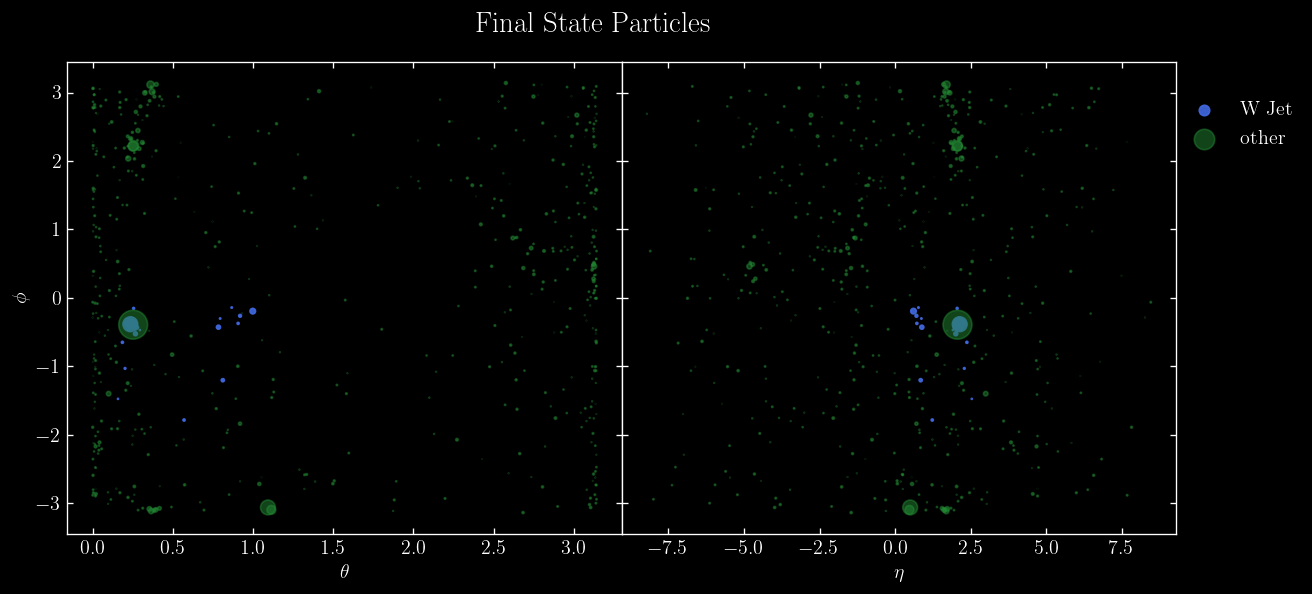

In [135]:
s=300
fig, (ax,ax1) = plt.subplots(1, 2, dpi=120,figsize=(10,5),sharey=True)
ax.scatter(from_parton.theta, from_parton.phi, label="W Jet",s=s*from_parton.pT/events[i].pT.max(),alpha=.9)
ax.scatter(notfrom_parton.theta.values[1:], notfrom_parton.phi.values[1:], 
           label="other",s=s*notfrom_parton.pT[1:]/events[i].pT.max(),alpha=.5)

ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\phi$")

ax1.scatter(from_parton.eta, from_parton.phi, label="W Jet",s=s*from_parton.pT/events[i].pT.max(),
            alpha=.9)
ax1.scatter(notfrom_parton.eta.values[1:], notfrom_parton.phi.values[1:], label="other",
            s=s*notfrom_parton.pT[1:]/events[i].pT.max(),alpha=.5)
ax1.set_xlabel(r"$\eta$")

fig.suptitle("Final State Particles")
fig.tight_layout(w_pad=0)
plt.legend(loc=(1, .8))
plt.show()

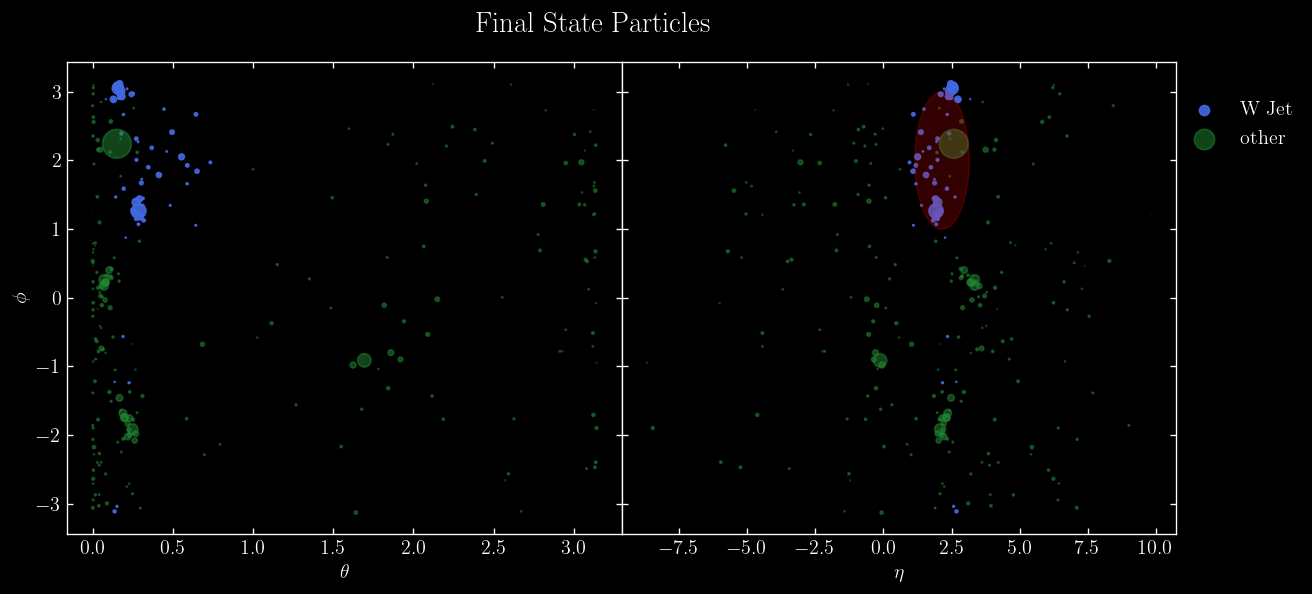

In [96]:
s=300
circle1 = plt.Circle((2.15, 2),1 , color='r',alpha=0.2)

fig, (ax,ax1) = plt.subplots(1, 2, dpi=120,figsize=(10,5),sharey=True)
ax.scatter(from_parton.theta, from_parton.phi, label="W Jet",s=s*from_parton.pT/events[i].pT.max(),alpha=.9)
ax.scatter(notfrom_parton.theta.values[1:], notfrom_parton.phi.values[1:], 
           label="other",s=s*notfrom_parton.pT[1:]/events[i].pT.max(),alpha=.5)


ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\phi$")

ax1.scatter(from_parton.eta, from_parton.phi, label="W Jet",s=s*from_parton.pT/events[i].pT.max(),
            alpha=.9)
ax1.scatter(notfrom_parton.eta.values[1:], notfrom_parton.phi.values[1:], label="other",
            s=s*notfrom_parton.pT[1:]/events[i].pT.max(),alpha=.5)
ax1.add_patch(circle1)
ax1.set_xlabel(r"$\eta$")

fig.suptitle("Final State Particles")
fig.tight_layout(w_pad=0)
plt.legend(loc=(1, .8))
plt.show()